# AirBnB Data Wrangling: Reviews

## About the Data

The data we are using for this project is 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
import glob as glob

## Load Data

In [20]:
def load_review_data(directory):
    #Read Reviews
    reviews_full = pd.read_csv(directory + 'reviews_full.csv').drop(columns=['Unnamed: 0'])
            
    return reviews_full

In [21]:
# Select City
country = 'united-states'
city = 'san-francisco'

# Directory
directory = 'data/' + country + '/' + city + '/'

# Download Review Data
reviews_full = load_review_data(directory)

In [22]:
reviews_full.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st..."
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...
4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...


In [23]:
reviews_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311277 entries, 0 to 311276
Data columns (total 6 columns):
listing_id       311277 non-null int64
id               311277 non-null int64
date             311277 non-null object
reviewer_id      311277 non-null int64
reviewer_name    311276 non-null object
comments         311198 non-null object
dtypes: int64(3), object(3)
memory usage: 14.2+ MB


## Clean 

In [24]:
# Drop Null Comments
reviews_full = reviews_full.dropna(subset=['comments'])

# Replace html 
reviews_full['comments'] = reviews_full['comments'].str.replace('\n',' ')

# Remove all ascii
reviews_full['comments'] = reviews_full['comments'].map(lambda x: re.sub(r'[^\x00-\x7F]+',' ', x))

# Dropna
reviews_full = reviews_full.dropna(subset=['comments'])

# Remove Stopwords & Lemmatize

In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

# Get Stopwords
stop_words = set(stopwords.words('english'))

# Get Puncuations
punctuations = set(string.punctuation)

def clean_text(doc):

    # Tokenize, Lemmatize, and Remove Stopwords
    tokens = [lemmatizer.lemmatize(word).lower() for word in nltk.word_tokenize(doc) if (word.lower() not in set(stop_words | punctuations) and (len(word) > 2))]
    
    return tokens

In [26]:
# Clean & Tokenize Overviews
reviews_full.loc[:,'tokens'] = reviews_full['comments'].apply(clean_text)

# Count Tokens
reviews_full['tokens_count'] = reviews_full['tokens'].map(lambda x: len(x))

27.720181363633444

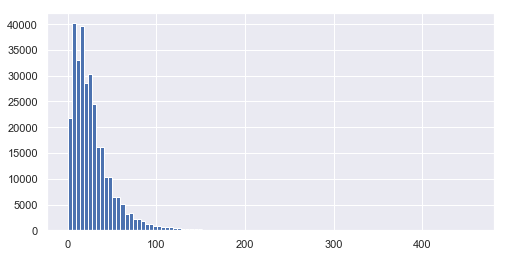

In [27]:
_ = plt.figure(figsize=(8,4))
_ = reviews_full['tokens_count'].hist(bins=100)
np.mean(reviews_full['tokens_count'])

# Get POS

In [28]:
def get_pos_sentences(data):
    # Tokenize each sentence into words: token_sentences
    token_sentences = [nltk.word_tokenize(re.sub(r'[^\x00-\x7F]+',' ', sent)) for sent in data]

    # Tag each tokenized sentence into parts of speech: pos_sentences
    pos_sentences = [nltk.pos_tag(sent) for sent in token_sentences]
    return pos_sentences

In [ ]:
# Initialize TextExtraction with DS Skills Listing
pos_overviews_reviews = get_pos_sentences(reviews_full['comments'])

## Non-NER

In [ ]:
def get_name_entities(pos_sentences):
    """Return Name Entities List"""
    # Create the named entity chunks: chunked_sentences
    chunked_sentences = nltk.ne_chunk_sents(pos_sentences, binary=True)
        
    # Chunk List per Listing
    listing_chunk_list = []

    # Test for stems of the tree with 'NE' tags
    for sent in chunked_sentences:
        chunks_list = []
        for chunk in sent:
            if hasattr(chunk, "label") and chunk.label() == "NE":
                chunks_list.append(chunk.leaves())

        #Append List of Chunks
        listing_chunk_list.append(chunks_list)
        
    # Chunks to List of Words
    listing_name_entity_list = [[' '.join([word[0] for word in chunk]) for chunk in chunk_list] for chunk_list in listing_chunk_list]
                
    return listing_name_entity_list

In [ ]:
# Extract Name Entities
ner_overviews_reviews = get_name_entities(pos_overviews_reviews)

In [ ]:
# Reset Index
reviews_full = reviews_full.reset_index(drop=True)

In [ ]:
# Add Name Entities to Df
reviews_full['name_entities'] = pd.Series(ner_overviews_reviews)

In [ ]:
# Count Name Entities
reviews_full['name_entities_count'] = reviews_full['name_entities'].map(lambda x: len(x))

In [ ]:
reviews_full.head()

## Delete Name Entities

In [ ]:
def del_name_entities(row):
    name_entities = row.name_entities
    comments_w_ne = row.comments
    
    for ne in name_entities:
        comments_w_ne = comments_w_ne.replace(ne, '')
        
    return comments_w_ne

In [ ]:
# 
reviews_full['comments_no_ne'] = reviews_full.apply(del_name_entities, 1)

### Count No NER Tokens

In [ ]:
# Clean & Tokenize Overviews
reviews_full['no_ne_tokens'] = reviews_full['comments_no_ne'].apply(clean_text)

# Count Tokens
reviews_full['no_ne_tokens_count'] = reviews_full['no_ne_tokens'].map(lambda x: len(x))

In [ ]:
reviews_full['no_ne_tokens_count'].hist(bins=50)

## Get Nouns

In [ ]:
def get_nouns(pos_sentences):
    """Return Noun List"""
    # Noun Codes
    noun_code = ['NN','NNS','NNP','NNPS']
    
    # Get Nouns
    noun_list = [[word[0].lower() for word in sent if word[1] in noun_code] for sent in pos_sentences]

    #Lemmatize
    lemmatizer = WordNetLemmatizer()
    noun_lem_list = [[lemmatizer.lemmatize(noun) for noun in noun_sent] for noun_sent in noun_list]
        
    return noun_lem_list

In [ ]:
# Add Nouns to DF
reviews_full['nouns'] = get_nouns(pos_overviews_reviews)

# Count Nouns Per Review
reviews_full['nouns_counts'] = reviews_full['nouns'].map(lambda x: len(x))

## Get Verbs

In [ ]:
def get_verbs(pos_sentences):
    """Return Verbs"""
    # Codes
    verb_code = ['VBG','VB','VBD','VBN','VBZ']

    # Get List of Adjectives
    verb_list = [[word[0].lower() for word in sent if word[1] in verb_code] for sent in pos_sentences]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    verb_lem_list = [[lemmatizer.lemmatize(verb, 'v') for verb in verb_sent] for verb_sent in verb_list]
        
    return verb_lem_list

In [ ]:
# Add Verbs Tokens to DF
reviews_full['verbs'] = get_verbs(pos_overviews_reviews)

# Count Verbs Per Review
reviews_full['verbs_counts'] = reviews_full['verbs'].map(lambda x: len(x))

## Get Adjectives

In [ ]:
def get_adjectives(pos_sentences):
    """Adjective List"""
    # Codes
    adj_code = ['JJ','JJR','JJS']

    # Get List of Adjectives
    adj_list = [[word[0].lower() for word in sent if word[1] in adj_code] for sent in pos_sentences]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    adj_lem_list = [[lemmatizer.lemmatize(adj, 'a') for adj in adj_sent] for adj_sent in adj_list]
        
    return adj_lem_list

In [ ]:
# Add Adjectives to DF
reviews_full['adjectives'] = get_adjectives(pos_overviews_reviews)

# Count Adjectives Per Review
reviews_full['adjectives_counts'] = reviews_full['adjectives'].map(lambda x: len(x))

## Clean

In [ ]:
# Organize Columns
review_cols = ['listing_id','id','date','comments','tokens','tokens_count','name_entities','name_entities_count','comments_no_ne','no_ne_tokens','no_ne_tokens_count','nouns','nouns_counts','verbs','verbs_counts','adjectives','adjectives_counts']
reviews_full = reviews_full[review_cols]

In [ ]:
reviews_full.head(3)

### Export To CSV

In [ ]:
reviews_full.shape

In [ ]:
reviews_full.to_csv(directory + 'interim/review_wrangled.csv', sep=';')